In [1]:
import h5py
import numpy as np
import os
import pandas as pd
from pathlib import Path
import readgadget
import scipy
import subprocess
import time

from os import listdir
from os.path import isfile, join

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import SymLogNorm

%load_ext autoreload
%autoreload 2
import bacco
import bacco.probabilistic_bias as pb

import sys
sys.path.append('../code')
import utils

Importing pyfftw first


2024-05-14 11:39:45.616745: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-14 11:39:48.672929: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-14 11:39:48.677701: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 11:40:08.339781: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-05-14 11:40:35.684218: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gp

In [3]:
fn_idxs = '../data/idxs_camelssam_in_emu_bounds.dat'
idxs_sam_inbounds = np.loadtxt(fn_idxs, dtype=int)
print(f'{len(idxs_sam_inbounds)} of SAMs have cosmo params in bounds') 
# idx_sam = 12 not working!! first in idxs_sam_inbounds, avoid w this line:
#idxs_sam = idxs_sam_inbounds[1:11]

tag_pbpfit = ''
dir_pbp = f'../data/probabilistic_bias_params/bias_params{tag_pbpfit}'
idxs_sam = [idx_sam for idx_sam in np.arange(0, 1000) \
            if os.path.isfile(f'{dir_pbp}/bias_params_LH_{idx_sam}.npy')]
if 12 in idxs_sam:
    idxs_sam.pop(12) # bad for some reason
print(idxs_sam)
print(len(idxs_sam))
    

169 of SAMs have cosmo params in bounds
[16, 17, 18, 20, 28, 48, 52, 58, 65, 70, 79, 85, 88, 98, 113, 116, 118, 131, 142, 146, 148, 157, 160, 161, 167, 168, 172, 176, 180, 182, 195, 197, 212, 214, 224, 232, 238, 243, 253, 258, 260, 262, 267, 268, 272, 277, 279, 284, 287, 289, 290, 296, 299, 313, 318, 319, 332, 341, 342, 345, 355, 362, 365, 366, 370, 372, 374, 385, 389, 390, 409, 424, 429, 431, 439, 441, 443, 444, 456, 459, 461, 476, 484, 488, 489, 518, 522, 523, 536, 537, 540, 543, 552, 554, 557, 558, 560, 567, 570, 574, 578, 600, 601, 602, 609, 619, 627, 639, 646, 648, 663, 667, 671, 681, 682, 688, 691, 694, 697, 699, 704, 713, 715, 717, 724, 728, 731, 734, 746, 748, 749, 769, 774, 780, 782, 786, 791, 798, 805, 807, 810, 811, 815, 818, 822, 828, 841, 855, 856, 858, 864, 867, 884, 888, 895, 896, 898, 903, 905, 931, 946, 948, 966, 969, 976, 980, 981, 987]
168


In [4]:
ndens_target = 0.003
tag_pk = f'_n{ndens_target}_hMpc'
tag_bpfit = '_kmax0.5'
#tag_bpfit = ''

In [5]:
bias_param_names = ['b1', 'b2', 'bs2']
pbias_param_names = ["J2", "J22", "J2=2"]
# bias_param_names_emu = ['b1', 'b2', 'bs2', 'bl']
# bias_param_names_pb = ['b1', 'b2', 'bdeltal', 'bl', 'bl2']
# idxs_bp_emu = [bias_param_names_emu.index(param_name) for param_name in bias_param_names]
# idxs_bp_pb = [bias_param_names_pb.index(param_name) for param_name in bias_param_names]

In [6]:
bias_to_pbias_param_name_dict = {'b1': 'J2',
                                 'b2': 'J22',
                                 'bs2': 'J2=2'}
pbias_to_bias_param_name_dict = {'J2': 'b1',
                                 'J22': 'b2',
                                 'J2=2': 'bs2'}
bias_param_labels = {'b1': r'$b_1$', 
                     'b2': r'$b_2$', 
                     'bs2': r'$b_{s^2}$', 
                     'bl': r'$b_{\nabla^2 \delta}$',
                    }
bounds_dict = {'b1': [-5, 20],
                'b2': [-5, 10],
                'bs2': [-10, 20],
                'bl': [-20, 30],
                'Asn': [0, 2],
                }
bias_param_names_nob1 = bias_param_names.copy()
bias_param_names_nob1.remove('b1')

In [8]:
def pbias_params_to_bias_params(pbias_param_dict, bias_param_names):
    def _f_J2(J2):
        return J2
    def _f_J22(J22):
        return J22
    # 1/2 bJ2=2 = bK2
    def _f_J2__2(J2__2):
        return 0.5*J2__2
    relation_dict = {'J2': _f_J2,
                     'J22': _f_J22,
                     'J2=2': _f_J2__2}
    pbias_param_names = [bias_to_pbias_param_name_dict[bpn] for bpn in bias_param_names]
    bias_params = [relation_dict[pbpn](pbias_param_dict[pbpn]) for pbpn in pbias_param_names]
    return bias_params

In [9]:

bp_arr = []
pbp_arr = []
pbp_cov_arr = []
for i, idx_sam in enumerate(idxs_sam):
#for i, idx_sam in enumerate(idxs_sam[:30]):

    fn_bp = f'../data/bias_params/bias_params{tag_pk}{tag_bpfit}/bias_params_LH_{idx_sam}.npy'
    #fn_bp = f'../data/bias_params_bestfit_bltoonarrowbounds/bias_params_LH_{idx_sam}.npy'
    if not os.path.exists(fn_bp):
        print(f"Bias param file {fn_bp} doesn't exist, skipping")
        bp_arr.append([np.nan for bp_name in bias_param_names])
        continue
    
    fn_pbp = f'{dir_pbp}/bias_params_LH_{idx_sam}.npy'
    #fn_bp = f'../data/bias_params_bestfit_bltoonarrowbounds/bias_params_LH_{idx_sam}.npy'
    if not os.path.exists(fn_pbp):
        print(f"Prob bias param file {fn_bp} doesn't exist, skipping")
        pbp_arr.append([np.nan for bp_name in bias_param_names])
        continue
    
    bias_params = np.load(fn_bp, allow_pickle=True).item()
    bp_arr.append([bias_params[bp_name] for bp_name in bias_param_names])

    # bs2 is not actually that in pbias!! its bdeltal! not including
    pbias_data = np.load(fn_pbp, allow_pickle=True)
    pbias_params_orig = pbias_data[0]
    #pbias_params = pbias_params_to_bias_params(pbias_params_orig.keys(), pbias_params_orig.values())
    pbias_params = pbias_params_to_bias_params(pbias_params_orig, bias_param_names)
    pbp_arr.append(pbias_params)
    
    #pbp_arr.append([pbias_params[bp_name] for bp_name in bias_param_names])
    bias_param_names_pb = [pbias_to_bias_param_name_dict[pbpn] for pbpn in pbias_params_orig]
    idxs_bp_pb = [bias_param_names_pb.index(param_name) for param_name in bias_param_names]
    pbias_cov = pbias_data[1]
    pbp_cov_arr.append([pbias_cov[idx_bp,idx_bp] for idx_bp in idxs_bp_pb])
    
bp_arr = np.array(bp_arr)
pbp_arr = np.array(pbp_arr)
pbp_cov_arr = np.array(pbp_cov_arr)
print(bp_arr.shape)
print(pbp_arr.shape)
print(pbp_cov_arr.shape)

(168, 3)
(168, 3)
(168, 3)


In [10]:

#sigma_0 = np.sqrt(np.mean(delta**2))

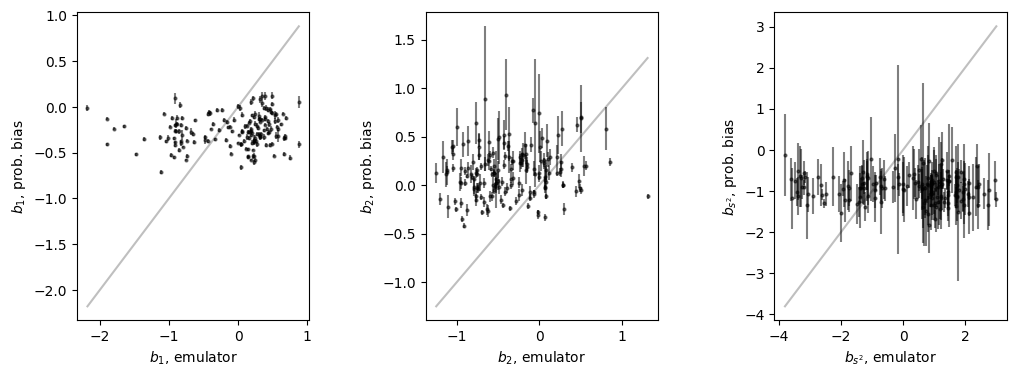

In [11]:
nrows, ncols = 1, 3
fig, axarr = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))#, sharex=True)
plt.subplots_adjust(hspace=0.1, wspace=0.5)

for bb, bp_name in enumerate(bias_param_names):
    xmin = min(np.min(bp_arr[:,bb]), np.min(pbp_arr[:,bb]))
    xmax = max(np.max(bp_arr[:,bb]), np.max(pbp_arr[:,bb]))
    xx = np.linspace(xmin, xmax)
    axarr[bb].plot(xx, xx, color='grey', alpha=0.5)    
    
    #axarr[bb].scatter(bp_arr[:,bb], pbp_arr[:,bb], marker='o', s=4, color='k')
    axarr[bb].errorbar(bp_arr[:,bb], pbp_arr[:,bb], yerr=pbp_cov_arr[:,bb], 
                       marker='o', markersize=2, color='k', ls='None', alpha=0.5)
    axarr[bb].set_xlabel(f'{bias_param_labels[bp_name]}, emulator')
    axarr[bb].set_ylabel(f'{bias_param_labels[bp_name]}, prob. bias')
    
    #axarr[bb].set_xlim(bounds_dict[bp_name])
    #axarr[bb].set_ylim(bounds_dict[bp_name])
        
# axarr[0].set_ylim(-1.5, 1.5)
# axarr[1].set_ylim(-4, 4)
# axarr[2].set_ylim(-10, 20)

In [12]:
fn_idxs = '../data/idxs_camelssam_in_emu_bounds.dat'
idxs_sam_inbounds = np.loadtxt(fn_idxs, dtype=int)
print(f'{len(idxs_sam_inbounds)} of SAMs have cosmo params in bounds') 
# idx_sam = 12 not working!! first in idxs_sam_inbounds, avoid w this line:
#idxs_sam = idxs_sam_inbounds[1:11]



169 of SAMs have cosmo params in bounds


In [13]:
tags_pbpfit_compare = ['_damp0.1', '', '_damp0.3', '_tracerqeul']
#tags_pbpfit_compare = ['', '_tracerqeul']

pbp_arrs_compare = []
pbp_cov_arrs_compare = []

for tag_pbpfit_compare in tags_pbpfit_compare:

    dir_pbp_compare = f'../data/probabilistic_bias_params/bias_params{tag_pbpfit_compare}'
    idxs_sam_compare = [idx_sam for idx_sam in np.arange(0, 1000) \
                if os.path.isfile(f'{dir_pbp_compare}/bias_params_LH_{idx_sam}.npy')]
    if 12 in idxs_sam_compare:
        idxs_sam_compare.pop(12) # bad for some reason
    print(len(idxs_sam_compare))
        

    pbp_arr_compare = []
    pbp_cov_arr_compare = []
    for i, idx_sam in enumerate(idxs_sam):

        fn_pbp = f'{dir_pbp_compare}/bias_params_LH_{idx_sam}.npy'
        #fn_bp = f'../data/bias_params_bestfit_bltoonarrowbounds/bias_params_LH_{idx_sam}.npy'
        if not os.path.exists(fn_pbp):
            print(f"Prob bias param file {fn_bp} doesn't exist, skipping")
            pbp_arr_compare.append([np.nan for bp_name in bias_param_names])
            pbp_cov_arr_compare.append([np.nan for bp_name in bias_param_names])
            continue
        
        # bs2 is not actually that in pbias!! its bdeltal! not including
        pbias_data = np.load(fn_pbp, allow_pickle=True)
        pbias_params_orig = pbias_data[0]
        #pbias_params = pbias_params_to_bias_params(pbias_params_orig.keys(), pbias_params_orig.values())
        pbias_params = pbias_params_to_bias_params(pbias_params_orig, bias_param_names)
        pbp_arr_compare.append(pbias_params)
        
        #pbp_arr.append([pbias_params[bp_name] for bp_name in bias_param_names])
        bias_param_names_pb = [pbias_to_bias_param_name_dict[pbpn] for pbpn in pbias_params_orig]
        idxs_bp_pb = [bias_param_names_pb.index(param_name) for param_name in bias_param_names]
        pbias_cov = pbias_data[1]
        pbp_cov_arr_compare.append([pbias_cov[idx_bp,idx_bp] for idx_bp in idxs_bp_pb])
        
    pbp_arrs_compare.append(pbp_arr_compare)
    pbp_cov_arrs_compare.append(np.array(pbp_cov_arr_compare))
    
pbp_arrs_compare = np.array(pbp_arrs_compare)
pbp_cov_arrs_compare = np.array(pbp_cov_arrs_compare)
print(pbp_arrs_compare.shape)
print(pbp_cov_arrs_compare.shape)
print(pbp_cov_arrs_compare[0].shape)

168
168
168
168
(4, 168, 3)
(4, 168, 3)
(168, 3)


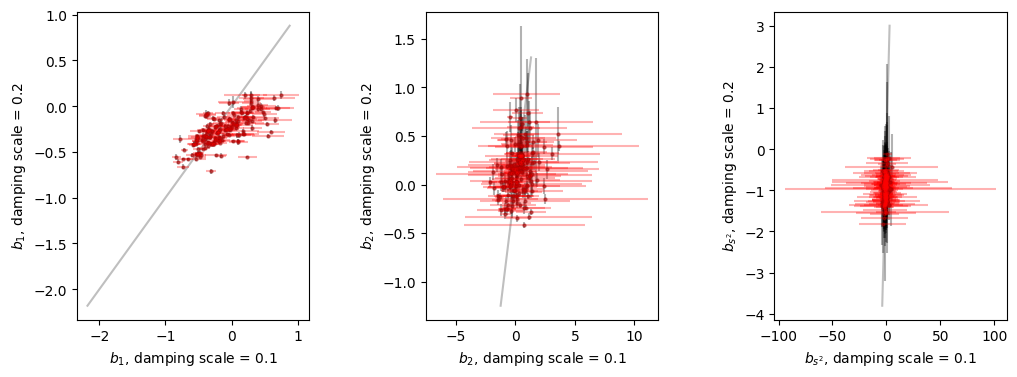

In [14]:
tag0, tag1 = ['_damp0.1', '']
idx_tag0, idx_tag1 = tags_pbpfit_compare.index(tag0), tags_pbpfit_compare.index(tag1)

nrows, ncols = 1, 3
fig, axarr = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))#, sharex=True)
plt.subplots_adjust(hspace=0.1, wspace=0.5)

for bb, bp_name in enumerate(bias_param_names):
    xmin = min(np.min(bp_arr[:,bb]), np.min(pbp_arr[:,bb]))
    xmax = max(np.max(bp_arr[:,bb]), np.max(pbp_arr[:,bb]))
    xx = np.linspace(xmin, xmax)
    axarr[bb].plot(xx, xx, color='grey', alpha=0.5)    
    
    #axarr[bb].scatter(bp_arr[:,bb], pbp_arr[:,bb], marker='o', s=4, color='k')
    axarr[bb].errorbar(pbp_arrs_compare[idx_tag0][:,bb], pbp_arrs_compare[idx_tag1][:,bb], 
                       yerr=pbp_cov_arrs_compare[idx_tag1][:,bb], 
                       marker='o', markersize=2, color='k', ls='None', alpha=0.3)
    axarr[bb].errorbar(pbp_arrs_compare[idx_tag0][:,bb], pbp_arrs_compare[idx_tag1][:,bb], 
                       xerr=pbp_cov_arrs_compare[idx_tag0][:,bb], 
                       marker='o', markersize=2, color='red', ls='None', alpha=0.3)
    axarr[bb].set_xlabel(f'{bias_param_labels[bp_name]}, damping scale = 0.1')
    axarr[bb].set_ylabel(f'{bias_param_labels[bp_name]}, damping scale = 0.2')
    
    #axarr[bb].set_xlim(bounds_dict[bp_name])
    #axarr[bb].set_ylim(bounds_dict[bp_name])
        
# axarr[0].set_ylim(-1.5, 1.5)
# axarr[1].set_ylim(-4, 4)
# axarr[2].set_ylim(-10, 20)

In [15]:
def bE_to_bL(bias_params_E, bias_param_names):
    # https://arxiv.org/pdf/2307.03226, eqn 2.5
    # print(bias_params_E)
    # print(bias_param_names)
    # bias_params_E_dict = dict(zip(list(bias_params_E), list(bias_param_names)))
    # bias_params_L_dict = {}
    # bias_params_L_dict['b1'] = bias_params_E_dict['b1']-1
    # bias_params_L_dict['b2'] = bias_params_E_dict['b2'] - 8/21*bias_params_L_dict['b1']
    # bias_params_L_dict['bs2'] = bias_params_E_dict['bs2'] - 4/7*bias_params_L_dict['b1']
    # return [bias_params_L_dict[bpn] for bpn in bias_param_names]
    #bias_params_E_dict = dict(zip(list(bias_params_E), list(bias_param_names)))
    bias_params_L = np.empty(bias_params_E.shape)
    idx_b1 = bias_param_names.index('b1')
    idx_b2 = bias_param_names.index('b2')
    idx_bs2 = bias_param_names.index('bs2')
    bias_params_L[:,idx_b1] = bias_params_E[:,idx_b1]-1
    bias_params_L[:,idx_b2] = bias_params_E[:,idx_b2] - 8/21*bias_params_L[:,idx_b1]
    bias_params_L[:,idx_bs2] = bias_params_E[:,idx_bs2] - 4/7*bias_params_L[:,idx_b1]
    print(bias_params_E[2])
    print(bias_params_L[2])
    return bias_params_L

[0.88810229 1.11896051 0.19285831]
[-0.11189771  1.16158821  0.25679986]


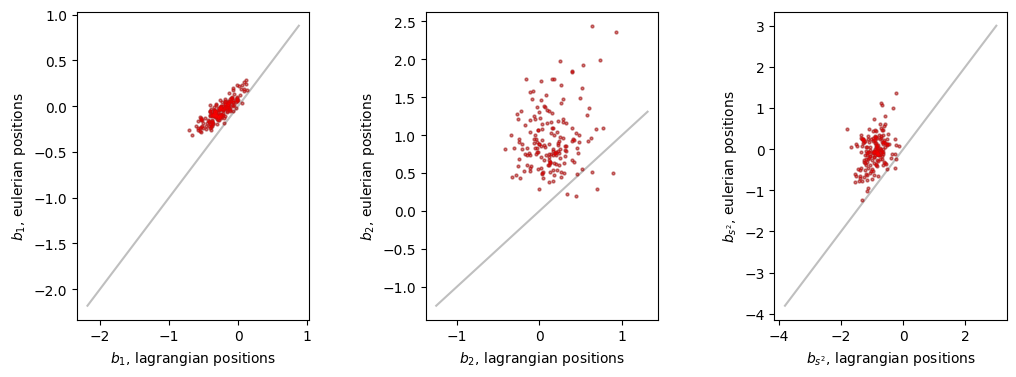

In [16]:
tag0, tag1 = ['', '_tracerqeul']
idx_tag0, idx_tag1 = tags_pbpfit_compare.index(tag0), tags_pbpfit_compare.index(tag1)
show_errorbars = False

nrows, ncols = 1, 3
fig, axarr = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))#, sharex=True)
plt.subplots_adjust(hspace=0.1, wspace=0.5)

pbp_arr_tag0 = pbp_arrs_compare[idx_tag0]
pbp_arr_tag1 = pbp_arrs_compare[idx_tag1]
if 'eul' in tag0: 
    pbp_arr_tag0 = bE_to_bL(pbp_arr_tag0, bias_param_names)
if 'eul' in tag1: 
    pbp_arr_tag1 = bE_to_bL(pbp_arr_tag1, bias_param_names)

for bb, bp_name in enumerate(bias_param_names):
    xmin = min(np.min(bp_arr[:,bb]), np.min(pbp_arr[:,bb]))
    xmax = max(np.max(bp_arr[:,bb]), np.max(pbp_arr[:,bb]))
    xx = np.linspace(xmin, xmax)
    axarr[bb].plot(xx, xx, color='grey', alpha=0.5)    
    
    #axarr[bb].scatter(bp_arr[:,bb], pbp_arr[:,bb], marker='o', s=4, color='k')
    bval0, bval1 = pbp_arr_tag0[:,bb], pbp_arr_tag1[:,bb]
    # if 'eul' in tag0:
    #     # b_E = 1 + b_L
    #     bval0 -= 1
    # if 'eul' in tag1:
    #     bval1 -= 1
    
    axarr[bb].errorbar(bval0, bval1, 
                       #yerr=pbp_cov_arrs_compare[idx_tag1][:,bb], 
                       yerr=None,
                       marker='o', markersize=2, color='k', ls='None', alpha=0.3)
    axarr[bb].errorbar(bval0, bval1, 
                       #xerr=pbp_cov_arrs_compare[idx_tag0][:,bb], 
                       xerr=None,
                       marker='o', markersize=2, color='red', ls='None', alpha=0.3)
    axarr[bb].set_xlabel(f'{bias_param_labels[bp_name]}, lagrangian positions')
    axarr[bb].set_ylabel(f'{bias_param_labels[bp_name]}, eulerian positions')
    
    #axarr[bb].set_xlim(bounds_dict[bp_name])
    #axarr[bb].set_ylim(bounds_dict[bp_name])
        
# axarr[0].set_ylim(-1.5, 1.5)
# axarr[1].set_ylim(-4, 4)
# axarr[2].set_ylim(-10, 20)

Text(0, 0.5, '$b_2$')

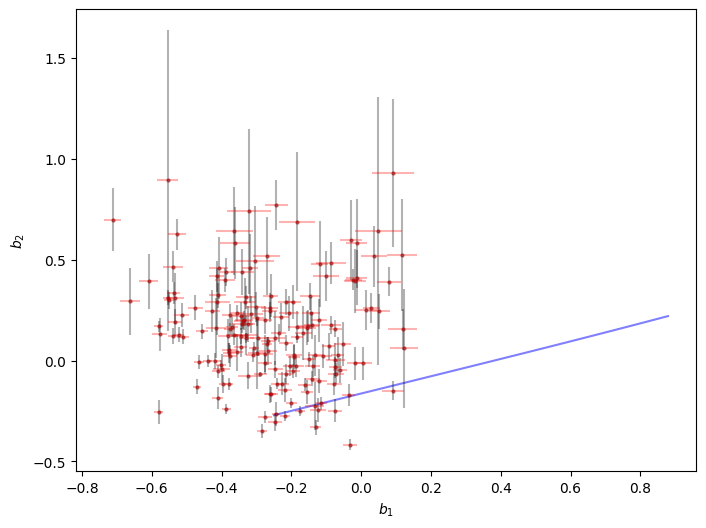

In [17]:
tag0, tag1 = ['', '']
idx_tag0, idx_tag1 = tags_pbpfit_compare.index(tag0), tags_pbpfit_compare.index(tag1)

nrows, ncols = 1, 1
#fig, axarr = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))#, sharex=True)
#plt.subplots_adjust(hspace=0.1, wspace=0.5)
plt.figure(figsize=(8, 6))
ax = plt.gca()

bb0, bb1 = 0, 1

xmin = min(np.min(bp_arr[:,bb0]), np.min(pbp_arr[:,bb0]))
xmax = max(np.max(bp_arr[:,bb0]), np.max(pbp_arr[:,bb0]))
xx = np.linspace(-0.25, xmax)

b2_matteo = 0.01677*xx**3 - 0.005116*xx**2 + 0.4279*xx - 0.1635

ax.plot(xx, b2_matteo, color='blue', alpha=0.5)    

#axarr[bb].scatter(bp_arr[:,bb], pbp_arr[:,bb], marker='o', s=4, color='k')
ax.errorbar(pbp_arrs_compare[idx_tag0][:,bb0], pbp_arrs_compare[idx_tag1][:,bb1], 
                    yerr=pbp_cov_arrs_compare[idx_tag1][:,bb1], 
                    marker='o', markersize=2, color='k', ls='None', alpha=0.3)
ax.errorbar(pbp_arrs_compare[idx_tag0][:,bb0], pbp_arrs_compare[idx_tag1][:,bb1], 
                    xerr=pbp_cov_arrs_compare[idx_tag0][:,bb0], 
                    marker='o', markersize=2, color='red', ls='None', alpha=0.3)
ax.set_xlabel(f'{bias_param_labels[bias_param_names[bb0]]}')
ax.set_ylabel(f'{bias_param_labels[bias_param_names[bb1]]}')
    
    #axarr[bb].set_xlim(bounds_dict[bp_name])
    #axarr[bb].set_ylim(bounds_dict[bp_name])
        
# axarr[0].set_ylim(-1.5, 1.5)
# axarr[1].set_ylim(-4, 4)
# axarr[2].set_ylim(-10, 20)

Text(0, 0.5, '$b_2$')

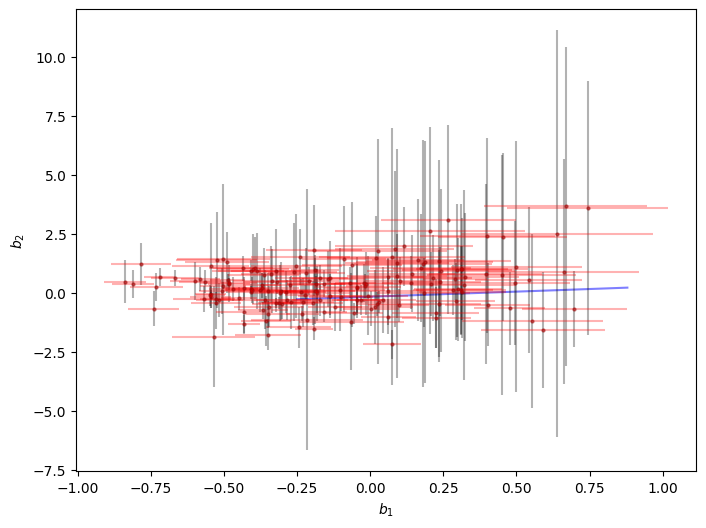

In [18]:
tag0, tag1 = ['_damp0.1', '_damp0.1']
idx_tag0, idx_tag1 = tags_pbpfit_compare.index(tag0), tags_pbpfit_compare.index(tag1)

nrows, ncols = 1, 1
#fig, axarr = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))#, sharex=True)
#plt.subplots_adjust(hspace=0.1, wspace=0.5)
plt.figure(figsize=(8, 6))
ax = plt.gca()

bb0, bb1 = 0, 1

xmin = min(np.min(bp_arr[:,bb0]), np.min(pbp_arr[:,bb0]))
xmax = max(np.max(bp_arr[:,bb0]), np.max(pbp_arr[:,bb0]))
xx = np.linspace(-0.25, xmax)

b2_matteo = 0.01677*xx**3 - 0.005116*xx**2 + 0.4279*xx - 0.1635

ax.plot(xx, b2_matteo, color='blue', alpha=0.5)    

#axarr[bb].scatter(bp_arr[:,bb], pbp_arr[:,bb], marker='o', s=4, color='k')
ax.errorbar(pbp_arrs_compare[idx_tag0][:,bb0], pbp_arrs_compare[idx_tag1][:,bb1], 
                    yerr=pbp_cov_arrs_compare[idx_tag1][:,bb1], 
                    marker='o', markersize=2, color='k', ls='None', alpha=0.3)
ax.errorbar(pbp_arrs_compare[idx_tag0][:,bb0], pbp_arrs_compare[idx_tag1][:,bb1], 
                    xerr=pbp_cov_arrs_compare[idx_tag0][:,bb0], 
                    marker='o', markersize=2, color='red', ls='None', alpha=0.3)
ax.set_xlabel(f'{bias_param_labels[bias_param_names[bb0]]}')
ax.set_ylabel(f'{bias_param_labels[bias_param_names[bb1]]}')
    
    #axarr[bb].set_xlim(bounds_dict[bp_name])
    #axarr[bb].set_ylim(bounds_dict[bp_name])
        
# axarr[0].set_ylim(-1.5, 1.5)
# axarr[1].set_ylim(-4, 4)
# axarr[2].set_ylim(-10, 20)

### Check as function of smoothing scale

(168,)
(168,)
(168,)


(-5.0, 5.0)

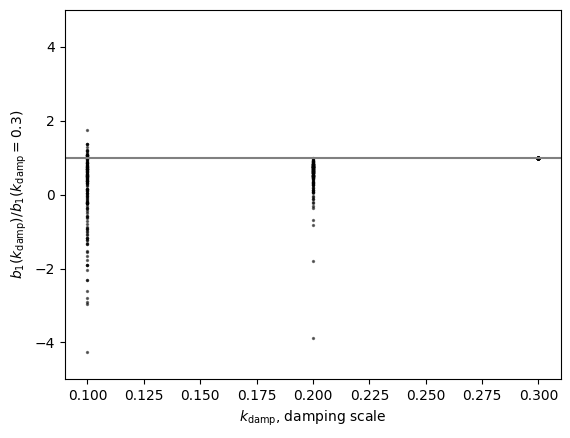

In [44]:
tag_base = '_damp0.3'
tags = ['_damp0.1', '', '_damp0.3']
idx_base = tags.index(tag_base)
ks_damp = [0.1, 0.2, 0.3]

idx_tag_base = tags_pbpfit_compare.index(tag_base)
bb0 = 0
b1_base = pbp_arrs_compare[idx_tag_base][:,bb0]

for i, tag in enumerate(tags):
    idx_tag = tags_pbpfit_compare.index(tag)

    b1 = pbp_arrs_compare[idx_tag][:,bb0]
    print(b1.shape)
    #print(len(ks_damp[i]*len(b1)))
    plt.scatter([ks_damp[i]]*len(b1), b1/b1_base, color='k', s=2, alpha=0.5)

plt.axhline(1.0, color='grey')
    
plt.xlabel(r'$k_\text{damp}$, damping scale')
b_label = bias_param_labels[bias_param_names[bb0]]
plt.ylabel(rf'{b_label}($k_\text{{damp}}$)/{b_label}($k_\text{{damp}}={ks_damp[idx_base]}$)')

plt.ylim(-5, 5)

(168,)
(168,)
(168,)


(-100.0, 100.0)

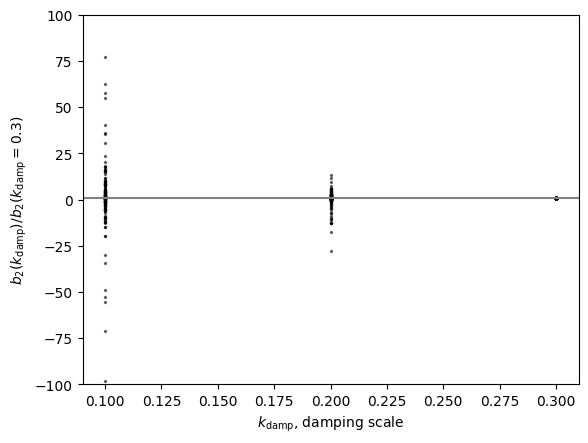

In [45]:
tag_base = '_damp0.3'
tags = ['_damp0.1', '', '_damp0.3']
idx_base = tags.index(tag_base)
ks_damp = [0.1, 0.2, 0.3]

idx_tag_base = tags_pbpfit_compare.index(tag_base)
bb0 = 1
b1_base = pbp_arrs_compare[idx_tag_base][:,bb0]

for i, tag in enumerate(tags):
    idx_tag = tags_pbpfit_compare.index(tag)

    b1 = pbp_arrs_compare[idx_tag][:,bb0]
    print(b1.shape)
    #print(len(ks_damp[i]*len(b1)))
    plt.scatter([ks_damp[i]]*len(b1), b1/b1_base, color='k', s=2, alpha=0.5)

plt.axhline(1.0, color='grey')
    
plt.xlabel(r'$k_\text{damp}$, damping scale')
b_label = bias_param_labels[bias_param_names[bb0]]
plt.ylabel(rf'{b_label}($k_\text{{damp}}$)/{b_label}($k_\text{{damp}}={ks_damp[idx_base]}$)')

plt.ylim(-100, 100)


### Check emulator fits

In [17]:
emu, emu_bounds, emu_param_names = utils.load_emu()

Loading l-bias lpt emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 whe

L-bias lpt emulator loaded in memory.
Loading smeared bao emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Smeared bao emulator loaded in memory.
Loading non-linear l-bias emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.1.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.1.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Nonlinear l-bias emulator loaded in memory.
HIIII


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [50]:
#idx_sam = 17
b1_arr = bp_arr[:,0]
idx_inarr = np.argmin(b1_arr)
idx_sam = idxs_sam[idx_inarr]
print(idx_sam)

715


In [51]:
cosmo_params = utils.setup_cosmo_emu(cosmo='CAMELS-SAM')
fn_params = '../data/params_CAMELS-SAM.dat'
df_params = pd.read_csv(fn_params, index_col='idx_LH')
Omega_m = df_params.loc[idx_sam, 'Omega_m']
sigma_8 = df_params.loc[idx_sam, 'sigma_8']
cosmo_params['omega_cold'] = Omega_m
cosmo_params['sigma8_cold'] = sigma_8


Setting up emulator cosmology


In [52]:

fn_pk = f'../data/pks/pks{tag_pk}/pk_LH_{idx_sam}.npy'
pk = np.load(fn_pk, allow_pickle=True).item()
k = pk['k']

In [53]:
fn_bp = f'../data/bias_params/bias_params{tag_pk}{tag_bpfit}/bias_params_LH_{idx_sam}.npy'
bias_params = np.load(fn_bp, allow_pickle=True).item()
print(bias_params)
bias_param_names_emu = ['b1', 'b2', 'bs2', 'bl']
bias_params_emu = [bias_params[bp_name] for bp_name in bias_param_names_emu]
_, pk_gg, _ = emu.get_galaxy_real_pk(bias=bias_params_emu, k=k_emu, 
                                             **cosmo_params)
A_sn = bias_params['Asn']
nbar = ndens_target
pk_emu = pk_gg + A_sn/nbar

{'b1': -2.1809082032280913, 'b2': 0.8077984792688897, 'bs2': -0.9585027475498864, 'bl': 0.8240840996176768, 'Asn': 2.0}


In [54]:
if np.max(k)>0.75:
    k_emu = k[k<0.75]
k_emu, pnn = emu.get_nonlinear_pnn(k=k_emu, **cosmo_params)

In [55]:
p11 = pnn[0]
p11_b1 = (1+bias_params['b1'])**2 * p11

Text(0, 0.5, '$P(k)$')

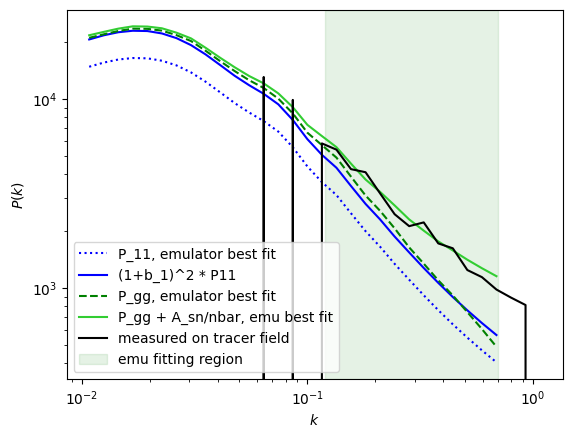

In [67]:
plt.plot(k_emu, p11, color='blue', ls=':', alpha=1, label='P_11, emulator best fit')
plt.plot(k_emu, p11_b1, color='blue', alpha=1, label='(1+b_1)^2 * P11')
plt.plot(k_emu, pk_gg, color='green', ls='--', alpha=1, label='P_gg, emulator best fit')
plt.plot(k_emu, pk_emu, color='limegreen', alpha=1, label='P_gg + A_sn/nbar, emu best fit')
plt.plot(k, pk['pk'], color='black', alpha=1, label='measured on tracer field')
plt.xscale('log')
plt.yscale('log')

plt.axvspan(0.12, 0.7, color='green', alpha=0.1, label='emu fitting region')

plt.legend()

plt.xlabel(r'$k$')
plt.ylabel(r'$P(k)$')

### saving sigmas

In [76]:
#tags_pbpfit_compare = ['_damp0.1', '', '_damp0.3', '_tracerqeul']
tags_pbpfit_compare = ['_wsigma0_damp0.1', '_wsigma0']

pbp_arrs_compare = []
pbp_cov_arrs_compare = []
sigma0_arrs_compare = []

for tag_pbpfit_compare in tags_pbpfit_compare:

    dir_pbp_compare = f'../data/probabilistic_bias_params/bias_params{tag_pbpfit_compare}'
    idxs_sam_compare = [idx_sam for idx_sam in np.arange(0, 1000) \
                if os.path.isfile(f'{dir_pbp_compare}/bias_params_LH_{idx_sam}.npy')]
    if 12 in idxs_sam_compare:
        idxs_sam_compare.pop(12) # bad for some reason
    print(len(idxs_sam_compare))
        
    pbp_arr_compare = []
    pbp_cov_arr_compare = []
    sigma0_arr_compare = []
    for i, idx_sam in enumerate(idxs_sam):
        fn_pbp = f'{dir_pbp_compare}/bias_params_LH_{idx_sam}.npy'
        #fn_bp = f'../data/bias_params_bestfit_bltoonarrowbounds/bias_params_LH_{idx_sam}.npy'
        if not os.path.exists(fn_pbp):
            print(f"Prob bias param file {fn_bp} doesn't exist, skipping")
            pbp_arr_compare.append([np.nan for bp_name in bias_param_names])
            pbp_cov_arr_compare.append(np.nan)
            sigma0_arr_compare.append(np.nan)
            continue
        
        # bs2 is not actually that in pbias!! its bdeltal! not including
        pbias_data = np.load(fn_pbp, allow_pickle=True).item()
        pbias_params_orig = pbias_data['bias_param_dict']
        #pbias_params = pbias_params_to_bias_params(pbias_params_orig.keys(), pbias_params_orig.values())
        pbias_params = pbias_params_to_bias_params(pbias_params_orig, bias_param_names)
        pbp_arr_compare.append(pbias_params)
        
        #pbp_arr.append([pbias_params[bp_name] for bp_name in bias_param_names])
        bias_param_names_pb = [pbias_to_bias_param_name_dict[pbpn] for pbpn in pbias_params_orig]
        idxs_bp_pb = [bias_param_names_pb.index(param_name) for param_name in bias_param_names]
        pbias_cov = pbias_data['bias_param_cov']
        pbp_cov_arr_compare.append([pbias_cov[idx_bp,idx_bp] for idx_bp in idxs_bp_pb])
        
        sigma0_arr_compare.append(pbias_data['sigma_0_damped'])
        
    pbp_arrs_compare.append(pbp_arr_compare)
    pbp_cov_arrs_compare.append(np.array(pbp_cov_arr_compare))
    #sigma0_arrs_compare.append(np.array(sigma0_arr_compare))
    sigma0_arrs_compare.append(sigma0_arr_compare)
    
pbp_arrs_compare = np.array(pbp_arrs_compare)
pbp_cov_arrs_compare = np.array(pbp_cov_arrs_compare)
sigma0_arrs_compare = np.array(sigma0_arrs_compare)
print(pbp_arrs_compare.shape)
print(pbp_cov_arrs_compare.shape)
print(pbp_cov_arrs_compare[0].shape)
print(sigma0_arrs_compare.shape)


115
Prob bias param file ../data/bias_params/bias_params_n0.003_hMpc_kmax0.5/bias_params_LH_987.npy doesn't exist, skipping
Prob bias param file ../data/bias_params/bias_params_n0.003_hMpc_kmax0.5/bias_params_LH_987.npy doesn't exist, skipping
Prob bias param file ../data/bias_params/bias_params_n0.003_hMpc_kmax0.5/bias_params_LH_987.npy doesn't exist, skipping
Prob bias param file ../data/bias_params/bias_params_n0.003_hMpc_kmax0.5/bias_params_LH_987.npy doesn't exist, skipping
Prob bias param file ../data/bias_params/bias_params_n0.003_hMpc_kmax0.5/bias_params_LH_987.npy doesn't exist, skipping
Prob bias param file ../data/bias_params/bias_params_n0.003_hMpc_kmax0.5/bias_params_LH_987.npy doesn't exist, skipping
Prob bias param file ../data/bias_params/bias_params_n0.003_hMpc_kmax0.5/bias_params_LH_987.npy doesn't exist, skipping
Prob bias param file ../data/bias_params/bias_params_n0.003_hMpc_kmax0.5/bias_params_LH_987.npy doesn't exist, skipping
Prob bias param file ../data/bias_pa

/tmp/ipykernel_365943/3465692171.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pbp_cov_arrs_compare.append(np.array(pbp_cov_arr_compare))


Prob bias param file ../data/bias_params/bias_params_n0.003_hMpc_kmax0.5/bias_params_LH_987.npy doesn't exist, skipping
Prob bias param file ../data/bias_params/bias_params_n0.003_hMpc_kmax0.5/bias_params_LH_987.npy doesn't exist, skipping
Prob bias param file ../data/bias_params/bias_params_n0.003_hMpc_kmax0.5/bias_params_LH_987.npy doesn't exist, skipping
Prob bias param file ../data/bias_params/bias_params_n0.003_hMpc_kmax0.5/bias_params_LH_987.npy doesn't exist, skipping
Prob bias param file ../data/bias_params/bias_params_n0.003_hMpc_kmax0.5/bias_params_LH_987.npy doesn't exist, skipping
Prob bias param file ../data/bias_params/bias_params_n0.003_hMpc_kmax0.5/bias_params_LH_987.npy doesn't exist, skipping
Prob bias param file ../data/bias_params/bias_params_n0.003_hMpc_kmax0.5/bias_params_LH_987.npy doesn't exist, skipping
Prob bias param file ../data/bias_params/bias_params_n0.003_hMpc_kmax0.5/bias_params_LH_987.npy doesn't exist, skipping
Prob bias param file ../data/bias_params

In [131]:
def renormalize_bias_params(bias_params, bias_param_names, sigma0):
    bias_params_renorm = np.empty(bias_params.shape)
    idx_b1 = bias_param_names.index('b1')
    idx_b2 = bias_param_names.index('b2')
    idx_bs2 = bias_param_names.index('bs2')
    bias_params_renorm[:,idx_b1] = bias_params[:,idx_b1]/sigma0**2
    bias_params_renorm[:,idx_b2] = (bias_params[:,idx_b2] - sigma0**2)/sigma0**4
    # back to orig; # 1/2 bJ2=2 = bK2
    J2e2 = 2*bias_params[:,idx_bs2]
    J2e2_renorm = 15*(3*J2e2 - 2*sigma0**2)/(4*sigma0**4)
    bias_params_renorm[:,idx_bs2] = 0.5*J2e2_renorm
    return bias_params_renorm

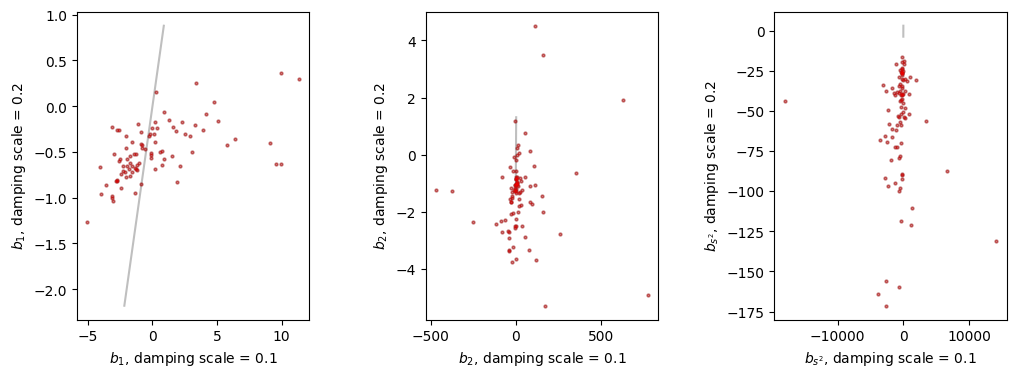

In [132]:
tag0, tag1 = ['_wsigma0_damp0.1', '_wsigma0']
idx_tag0, idx_tag1 = tags_pbpfit_compare.index(tag0), tags_pbpfit_compare.index(tag1)
show_errorbars = False

nrows, ncols = 1, 3
fig, axarr = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))#, sharex=True)
plt.subplots_adjust(hspace=0.1, wspace=0.5)

pbp_arr_tag0 = pbp_arrs_compare[idx_tag0]
pbp_arr_tag1 = pbp_arrs_compare[idx_tag1]

# TODO not sure what to do if need both eul and wsigma
if 'eul' in tag0: 
    pbp_arr_tag0 = bE_to_bL(pbp_arr_tag0, bias_param_names)
if 'eul' in tag1: 
    pbp_arr_tag1 = bE_to_bL(pbp_arr_tag1, bias_param_names)

# TODO also renormalize errors ??
if 'wsigma' in tag0: 
    pbp_arr_tag0 = renormalize_bias_params(pbp_arr_tag0, bias_param_names, 
                                           sigma0_arrs_compare[idx_tag0])
if 'wsigma' in tag1: 
    pbp_arr_tag1 = renormalize_bias_params(pbp_arr_tag1, bias_param_names,
                                           sigma0_arrs_compare[idx_tag1])

for bb, bp_name in enumerate(bias_param_names):
    xmin = min(np.min(bp_arr[:,bb]), np.min(pbp_arr[:,bb]))
    xmax = max(np.max(bp_arr[:,bb]), np.max(pbp_arr[:,bb]))
    xx = np.linspace(xmin, xmax)
    axarr[bb].plot(xx, xx, color='grey', alpha=0.5)    
    
    #axarr[bb].scatter(bp_arr[:,bb], pbp_arr[:,bb], marker='o', s=4, color='k')
    bval0, bval1 = np.array(pbp_arr_tag0[:,bb]), np.array(pbp_arr_tag1[:,bb])

    axarr[bb].errorbar(bval0, bval1, 
                       #yerr=pbp_cov_arrs_compare[idx_tag1][:,bb], 
                       yerr=None,
                       marker='o', markersize=2, color='k', ls='None', alpha=0.3)
    axarr[bb].errorbar(bval0, bval1, 
                       #xerr=pbp_cov_arrs_compare[idx_tag0][:,bb], 
                       xerr=None,
                       marker='o', markersize=2, color='red', ls='None', alpha=0.3)
    axarr[bb].set_xlabel(f'{bias_param_labels[bp_name]}, damping scale = 0.1')
    axarr[bb].set_ylabel(f'{bias_param_labels[bp_name]}, damping scale = 0.2')
    
    #axarr[bb].set_xlim(bounds_dict[bp_name])
    #axarr[bb].set_ylim(bounds_dict[bp_name])
        
# axarr[0].set_ylim(-1.5, 1.5)
# axarr[1].set_ylim(-4, 4)
# axarr[2].set_ylim(-10, 20)

In [73]:
tags_pbpfit_compare

['_damp0.1', '', '_damp0.3', '_tracerqeul']

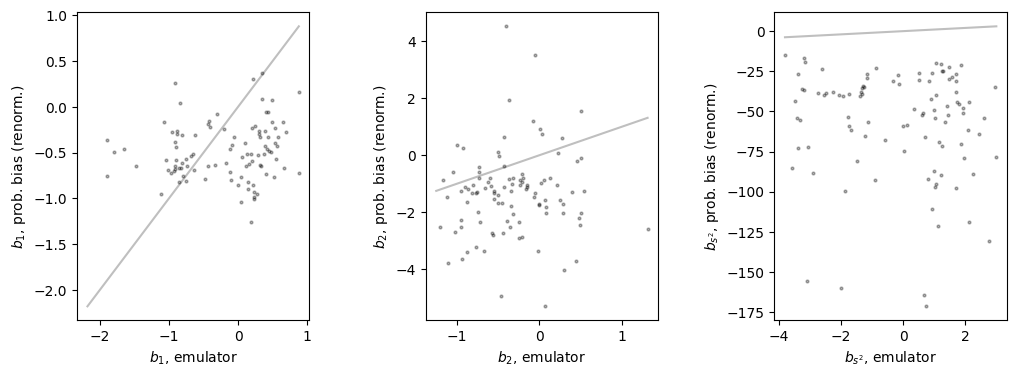

In [136]:
tag0 = '_wsigma0'
idx_tag0 = tags_pbpfit_compare.index(tag0)
show_errorbars = False

nrows, ncols = 1, 3
fig, axarr = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))#, sharex=True)
plt.subplots_adjust(hspace=0.1, wspace=0.5)

pbp_arr_tag0 = pbp_arrs_compare[idx_tag0]

# TODO not sure what to do if need both eul and wsigma
if 'eul' in tag0: 
    pbp_arr_tag0 = bE_to_bL(pbp_arr_tag0, bias_param_names)


# TODO also renormalize errors ??
if 'wsigma' in tag0: 
    pbp_arr_tag0 = renormalize_bias_params(pbp_arr_tag0, bias_param_names, 
                                           sigma0_arrs_compare[idx_tag0])
    
for bb, bp_name in enumerate(bias_param_names):
    xmin = min(np.min(bp_arr[:,bb]), np.min(pbp_arr[:,bb]))
    xmax = max(np.max(bp_arr[:,bb]), np.max(pbp_arr[:,bb]))
    xx = np.linspace(xmin, xmax)
    axarr[bb].plot(xx, xx, color='grey', alpha=0.5)    
    
    #axarr[bb].scatter(bp_arr[:,bb], pbp_arr[:,bb], marker='o', s=4, color='k')
    bval0 = np.array(pbp_arr_tag0[:,bb])

    axarr[bb].errorbar(bp_arr[:,bb], bval0, 
                       #yerr=pbp_cov_arrs_compare[idx_tag1][:,bb], 
                       yerr=None,
                       marker='o', markersize=2, color='k', ls='None', alpha=0.3)

    axarr[bb].set_xlabel(f'{bias_param_labels[bp_name]}, emulator')
    axarr[bb].set_ylabel(f'{bias_param_labels[bp_name]}, prob. bias (renorm.)')
    
    #axarr[bb].set_xlim(bounds_dict[bp_name])
    #axarr[bb].set_ylim(bounds_dict[bp_name])
        
# axarr[0].set_ylim(-1.5, 1.5)
# axarr[1].set_ylim(-4, 4)
# axarr[2].set_ylim(-10, 20)

In [74]:
tags_pbpfit_compare

['_damp0.1', '', '_damp0.3', '_tracerqeul']

In [1]:
# TODO can compute as integral of power spectrum, as in press schechter
np.mean(sigma0_arrs_compare[0], axis=0)

NameError: name 'np' is not defined

### Compare 